In [1]:
import mysql.connector
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import calendar
import datetime
from datetime import timedelta
import random
import sys, os
sys.path.append(r'C:\Users\Timothe\NasgoyaveOC\Professionnel\ThèseUNIC\CodeAnalyses\Comportement\BehavioralPerformances')
from Functions.ExtractFromDB import *
ColourValues = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9','C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'];

In [2]:
class MazeData:
    
    def __init__(self, trainingset):
        
        self.cnx = mysql.connector.connect(host="127.0.0.1",user="Tim",passwd="Turion162!",db="maze")
           
        cursor = self.cnx.cursor()
        query = ("""
            SELECT training_set_name, training_set_description FROM maze.training_set_def as ms
            where training_set_id = %s""")
        Add= (trainingset,)
        cursor.execute(query, Add)
        result=cursor.fetchall()
        cursor.close()
        Mlist = [y for x in result for y in x]
        print("Select: {} : {} : {}".format(trainingset,Mlist[0],Mlist[1]))
        
        self.TrSetNnb=trainingset
        self.TrSetName=Mlist[0]

        cursor = self.cnx.cursor()
        query = ("""
            SELECT distinct(mouse_number) FROM maze.mouses_sessions as ms
            INNER JOIN mouses as mo ON mo.mouses_id = ms.mouses_id
            where training_set_id = %s and session_status = 'active'
            order by mouse_number""")
        Add= (trainingset,)
        cursor.execute(query, Add)
        result=cursor.fetchall()
        cursor.close()
        self.MouseList = [y for x in result for y in x]
        
        cursor = self.cnx.cursor()
        query = ("""
                SELECT mouse_number, sd.session_id, count(id_session_detail) FROM session_detail as sd
                INNER JOIN mouses_sessions as ms ON ms.session_id = sd.session_id
                INNER JOIN mouses as mo ON mo.mouses_id = ms.mouses_id
                WHERE ms.training_set_id = %s AND event_value = 255 AND session_status = 'active'
                GROUP BY sd.session_id
                  """)
        Add= (trainingset,)
        cursor.execute(query, Add)
        result=cursor.fetchall()
        cursor.close()
        self.IndexStorage = np.asarray(result)
    
    def ExtractSequences(self,arglist):
        query = ("""
            SELECT event_value FROM session_detail sd
            WHERE session_id = %s AND event_value IN(""")
        i = 0
        for I in arglist :
            if i >= len(arglist)-1:
                query = query + str(I)
            else:
                query = query + str(I) + ", "  
            i = i+1   
        query = query + ") ORDER BY timestamp"
            
        #temp = np.empty([0,1])
        self.SessSeq_storage = {}
        for J in self.IndexStorage:
                    
            cursor = self.cnx.cursor()
            Add= (str(J[1]),)
            cursor.execute(query, Add)
            result=cursor.fetchall()
            cursor.close()
            buffR = [y for x in result for y in x]
            self.SessSeq_storage[J[1]] = buffR
        
        self.SessSeqRewd_storage = {}
        for J in self.IndexStorage:
            seqTemp = self.SessSeq_storage.get(J[1])
            ListTheorique=[]
            for i in seqTemp:
                if i == 3 or i == -4 or i == 1 or i == -2:
                    ListTheorique.append(1)# 1= Recomprense à Droite
                elif i == 4 or i == -3 or i == 2 or i == -1:
                    ListTheorique.append(2)# 2= Recomprense à Gauche
            self.SessSeqRewd_storage[J[1]]=ListTheorique
            
        self.SessSeqMouse_storage = {}
        for J in self.IndexStorage:
            seqTemp = self.SessSeq_storage.get(J[1])
            ListReele=[]
            for i in seqTemp:
                if i == 3 or i == -3 or i == 1 or i == -1:
                    ListReele.append(1)# 1= Souris à Droite
                elif i == 4 or i == -4 or i == 2 or i == -2:
                    ListReele.append(2)# 2= Souris à Gauche
            self.SessSeqMouse_storage[J[1]]=ListReele
            
            
    def CalulateSuccessrates(self,dicto,BinSizetrials,EjectionSize):
        Masterbinsize = BinSizetrials
        self.SuccesRate_storage = {}
        for J in self.IndexStorage :
            BinSizetrials = Masterbinsize
            seqTemp = dicto.get(J[1])
            if BinSizetrials != -1:
                nbofBins = math.floor(len(seqTemp)/BinSizetrials)
                remainder = len(seqTemp)%BinSizetrials
                
                if remainder >= EjectionSize:
                    nbofBins = nbofBins + 1
            else:
               
                if len(seqTemp) >= EjectionSize :
                    BinSizetrials = len(seqTemp)
                    nbofBins = 1
                else :
                    nbofBins = 0
            Results = np.zeros([nbofBins,3])
            
            binNb = 0

            for U in range(0,len(seqTemp)):
                 
                if U < BinSizetrials*nbofBins :
                    
                    if seqTemp[U] == 3 or seqTemp[U] == 4:
                        Results[binNb,1] = Results[binNb,1] + 1
                        
                    elif seqTemp[U] == -3 or seqTemp[U] == -4:
                        Results[binNb,0] = Results[binNb,0] + 1 #Number of errors
       
                    if BinSizetrials != -1:
                        if U-(binNb*BinSizetrials) >= BinSizetrials-1:
                            
                            Results[binNb,2] = Results[binNb,1]/(Results[binNb,1]+Results[binNb,0])
                            binNb = binNb + 1              
            
            if BinSizetrials != -1:
                if U < BinSizetrials*nbofBins-1  :
                    Results[binNb,2] = Results[binNb,1]/(Results[binNb,1]+Results[binNb,0])
                    
            elif nbofBins > 0 :
                Results[0,2] = Results[0,1]/(Results[0,1]+Results[0,0])
                
            self.SuccesRate_storage[J[1]] = Results            
            
        return self.SuccesRate_storage
                     
                
    def CalulateProbas(self,dicto,BinSizetrials,EjectionSize) :
        Masterbinsize = BinSizetrials
        self.Probas_storage = {}
        for J in self.IndexStorage :
            BinSizetrials = Masterbinsize
            seqTemp = dicto.get(J[1])
            if BinSizetrials != -1:

                nbofBins = math.floor((len(seqTemp))/BinSizetrials)
           
                remainder = (len(seqTemp))%BinSizetrials
          
                if remainder >= EjectionSize:
                    nbofBins = nbofBins + 1
                
            else:
                if len(seqTemp) >= EjectionSize :
                    BinSizetrials = len(seqTemp)
                    nbofBins = 1
                else :
                    nbofBins = 0
            Results = np.zeros([nbofBins,3])
            
            binNb = 0
           
            for U in range(1,len(seqTemp)):
   
                if U <= BinSizetrials * nbofBins :
                    if seqTemp[U] == seqTemp[U-1]:
                        Results[binNb,1] = Results[binNb,1] + 1
                        
                    elif seqTemp[U] != seqTemp[U-1]:
                        Results[binNb,0] = Results[binNb,0] + 1 # Number of times the mouse turns the opposite side after a trial end
       
                    if BinSizetrials != -1:
                        if U-(binNb*BinSizetrials) >= BinSizetrials:
               
                            Results[binNb,2] = Results[binNb,0]/(Results[binNb,1]+Results[binNb,0])
                            binNb = binNb + 1
           
            
            if BinSizetrials != -1:
                if U < BinSizetrials*nbofBins  :
           
                    Results[binNb,2] = Results[binNb,0]/(Results[binNb,1]+Results[binNb,0])
            elif nbofBins > 0 :
                Results[0,2] = Results[0,0]/(Results[0,1]+Results[0,0])
                
            self.Probas_storage[J[1]] = Results            
            
        return self.Probas_storage
            
    def Calulate_seqLENGTH(self,dicto):
        self.Len_storage = {}
        for J in self.IndexStorage :
            seqTemp = dicto.get(J[1])
            tempLen = np.zeros([1,3])
            tempLen[0,2] = len(seqTemp)
            self.Len_storage[J[1]] = tempLen
            
        return self.Len_storage
    
    def MakePlotlist(self,dicto,MouseNo):
        PlotList = np.zeros([0,0])
        NanList = np.zeros([0,0])

        for J in self.IndexStorage:

            if J[0]==MouseNo :

                BINS=dicto.get(J[1])
                if np.size(BINS,0) != 0 : 
       
                    for K in range(np.size(BINS,0)):
                        if K == 0:
                            NanList = np.append(NanList,BINS[K,2])
                        else:
                            NanList = np.append(NanList,np.nan)
                        PlotList = np.append(PlotList,BINS[K,2])
            
        return PlotList,NanList
    
def PasteUnfitArray(MasterArray,InsertedArray):
    print(np.size(MasterArray))
    print(np.size(InsertedArray))                    
            

Select: 26 : Phase3_unimodal_b3 : Phase 3 unimodal : choix droite ou gauche selon le stimulus présenté. Les stimulus sont uniquement tactiles
Select: 26 : Phase3_unimodal_b3 : Phase 3 unimodal : choix droite ou gauche selon le stimulus présenté. Les stimulus sont uniquement tactiles


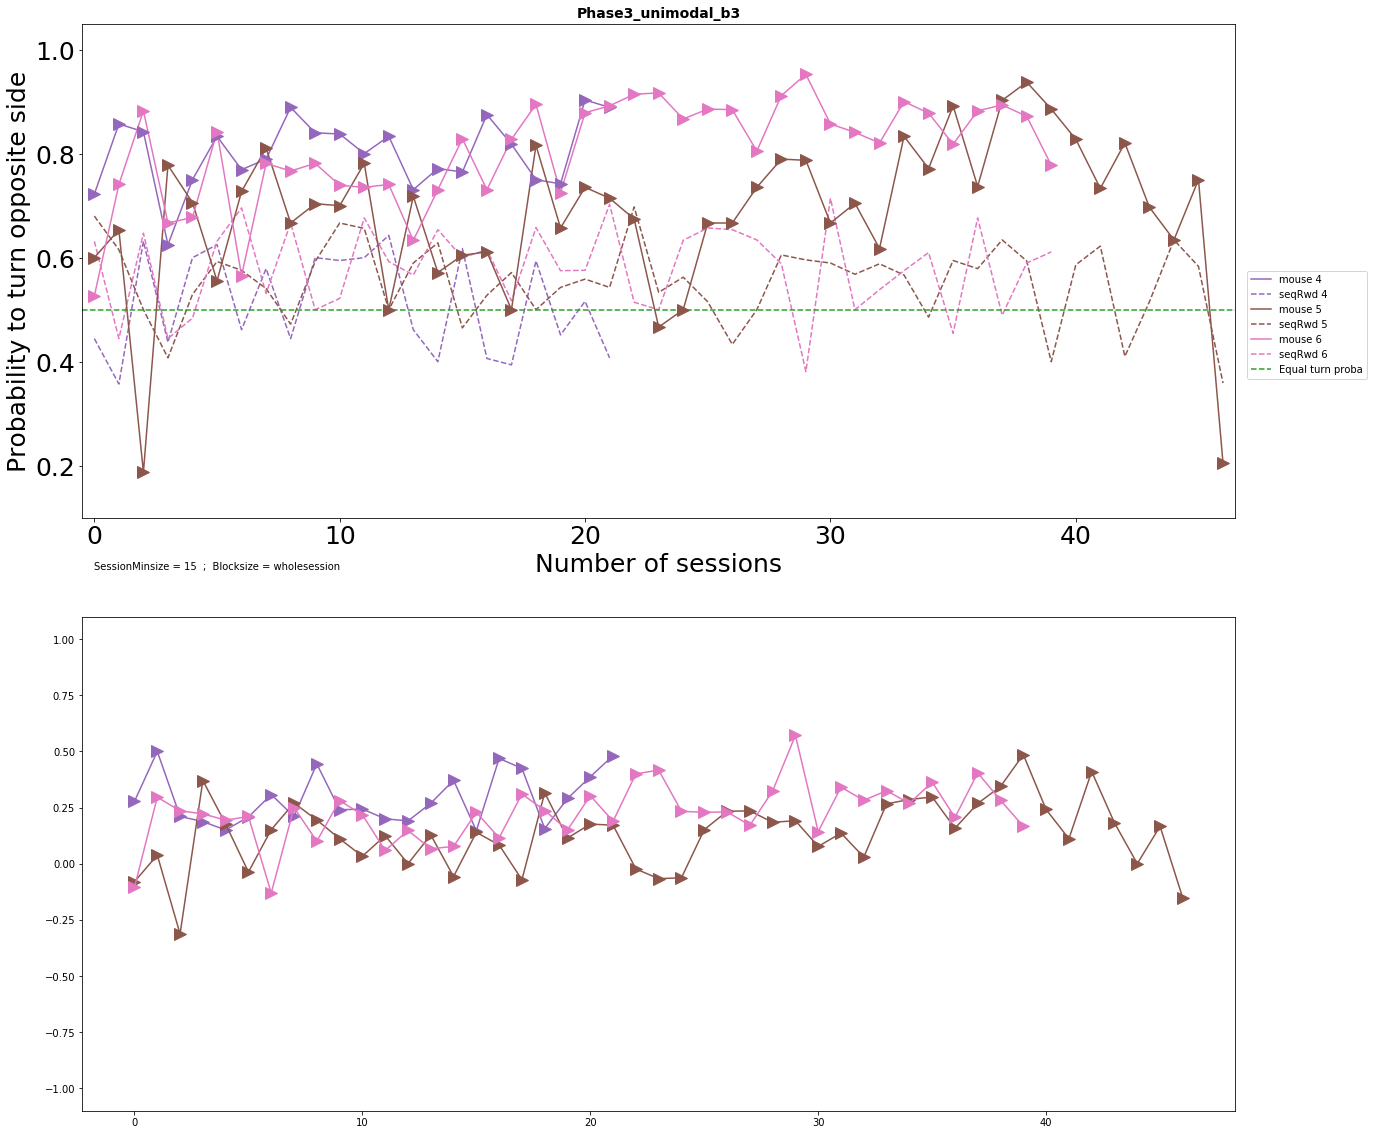

Select: 27 : Phase3_bimodal_a_b3 : Phase 3 bimodal A : choix droite ou gauche selon le stimulus présenté. Les stimulus sont éclairés
Select: 27 : Phase3_bimodal_a_b3 : Phase 3 bimodal A : choix droite ou gauche selon le stimulus présenté. Les stimulus sont éclairés


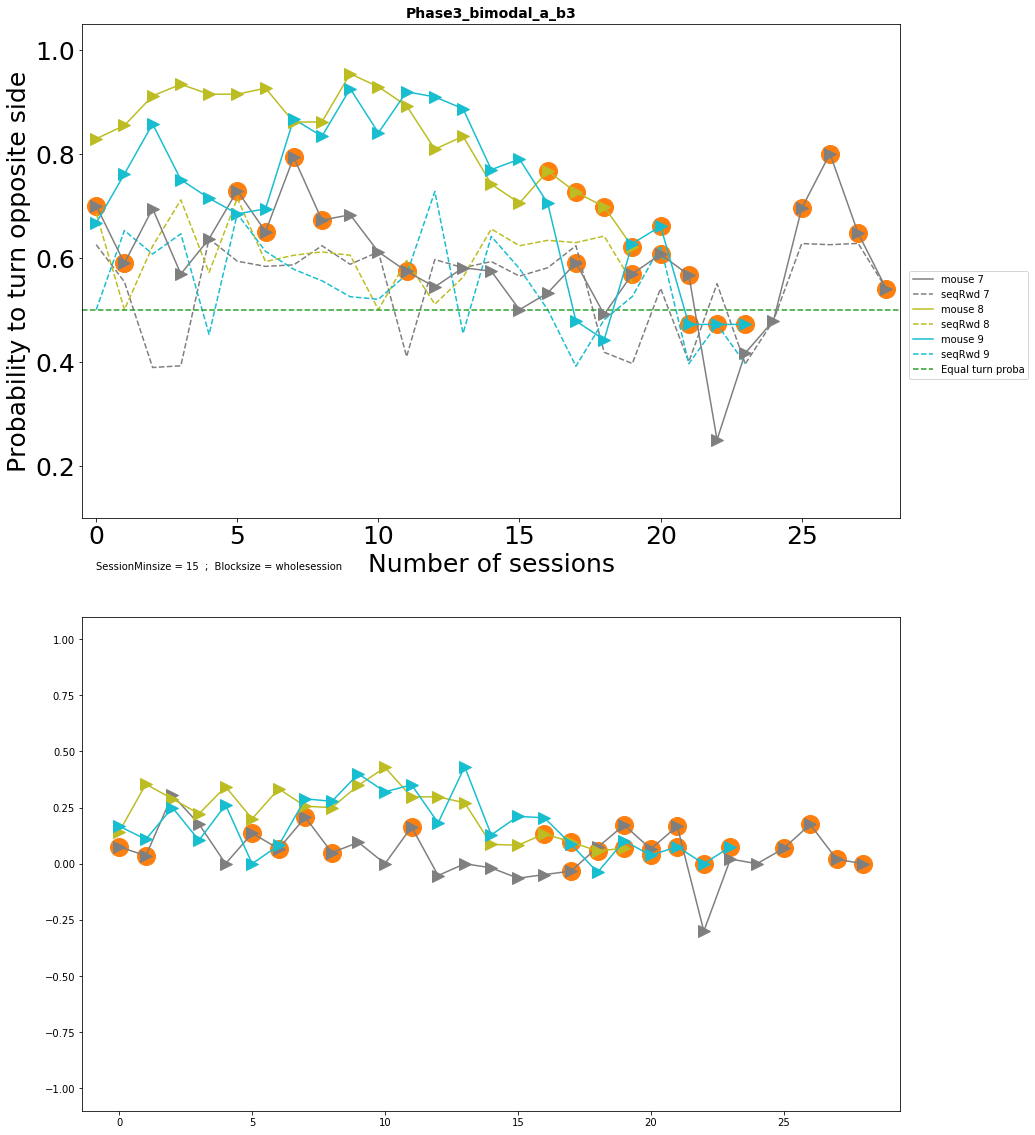

Select: 28 : Phase3_bimodal_b_b3 : Phase 3 bimodal B: choix droite ou gauche selon le stimulus présenté. Les stimulus sont très peu éclairés
Select: 28 : Phase3_bimodal_b_b3 : Phase 3 bimodal B: choix droite ou gauche selon le stimulus présenté. Les stimulus sont très peu éclairés


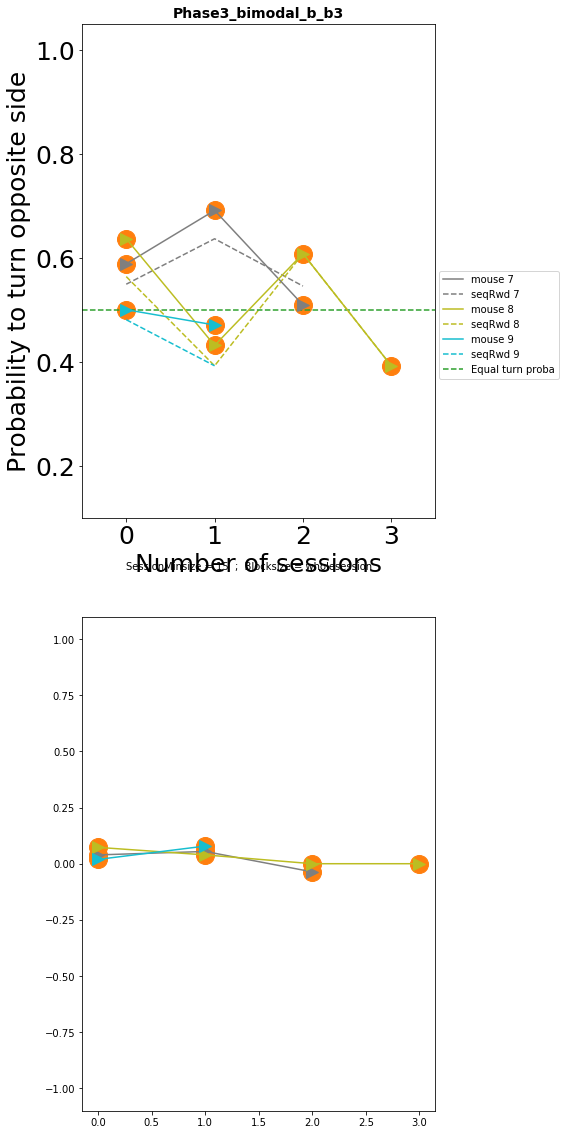

Select: 30 : Phase3_unimodal2_b3 : Phase 3 unimodal : choix droite ou gauche selon le stimulus présenté. Les stimulus sont uniquement tactiles
Select: 30 : Phase3_unimodal2_b3 : Phase 3 unimodal : choix droite ou gauche selon le stimulus présenté. Les stimulus sont uniquement tactiles


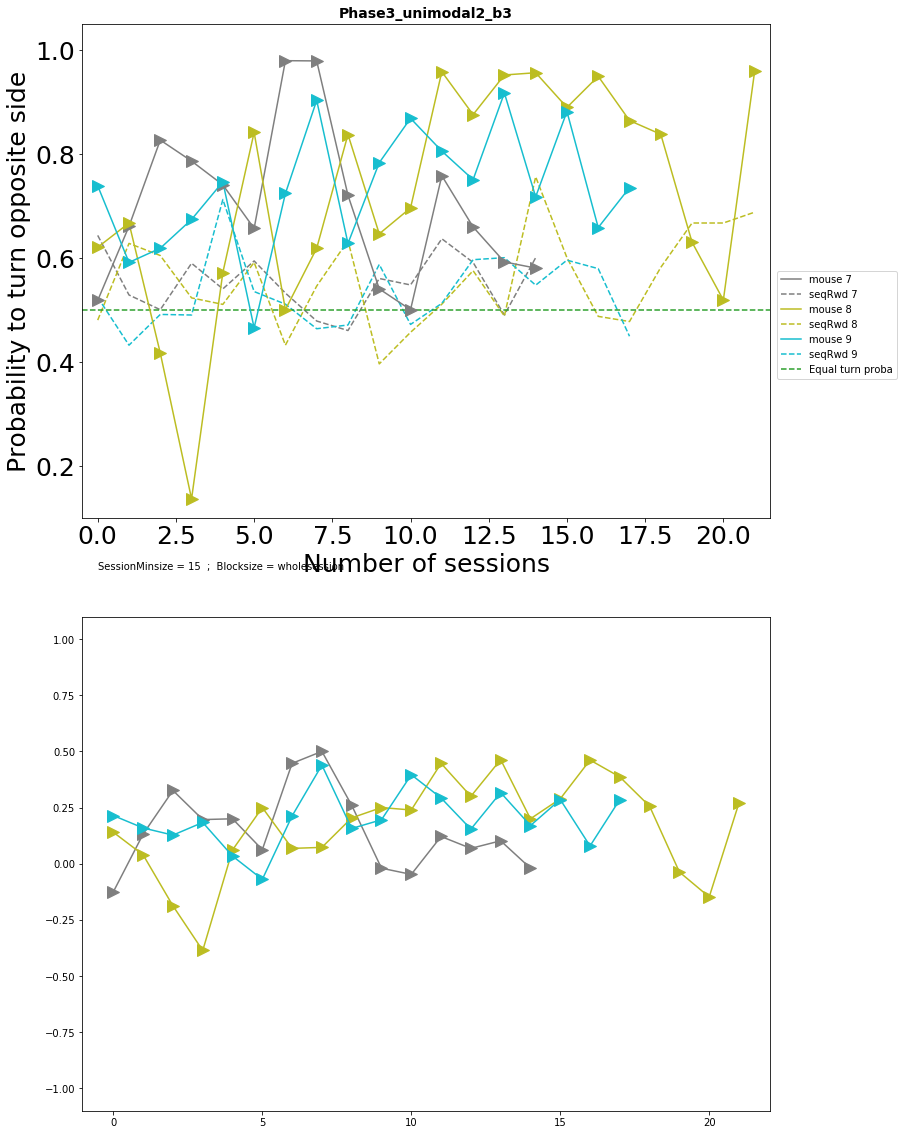

Select: 32 : PhaseX_LedSide_b2 : Phase annexe : souris n'utilisant pas les timuli tactile mais plutôt la position indiquée par les leds proches des lickports pour tourner
Select: 32 : PhaseX_LedSide_b2 : Phase annexe : souris n'utilisant pas les timuli tactile mais plutôt la position indiquée par les leds proches des lickports pour tourner


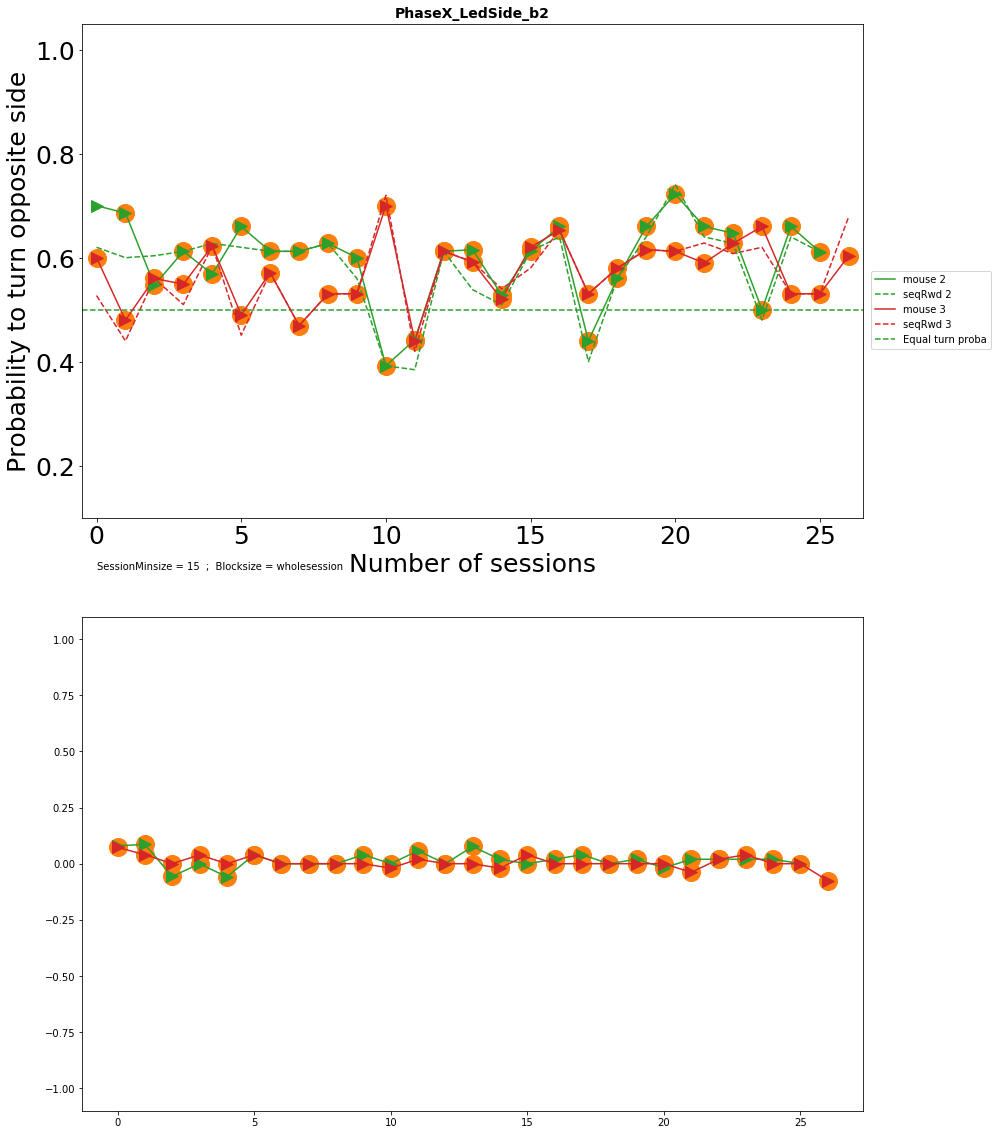

Mean of Mouse proba on < 90% success trials nan
Mean of Mouse proba on >= 90% success trials nan
Mean mouse -90% correct nan
SD mouse -90% correct nan
Var mouse -90% correct nan
Mean mouse +90% correct nan
SD mouse +90% correct nan
Var mouse +90% correct nan
Mean of seq proba to alternate 0.6978821112023071
SD mouse total 0.15111066998452993
Var mouse total 0.022834434583173514
Mean rew seq total 0.5570467634102387
SD rew seq total 0.08330295360205363
Var rew seq total 0.0069393820788259


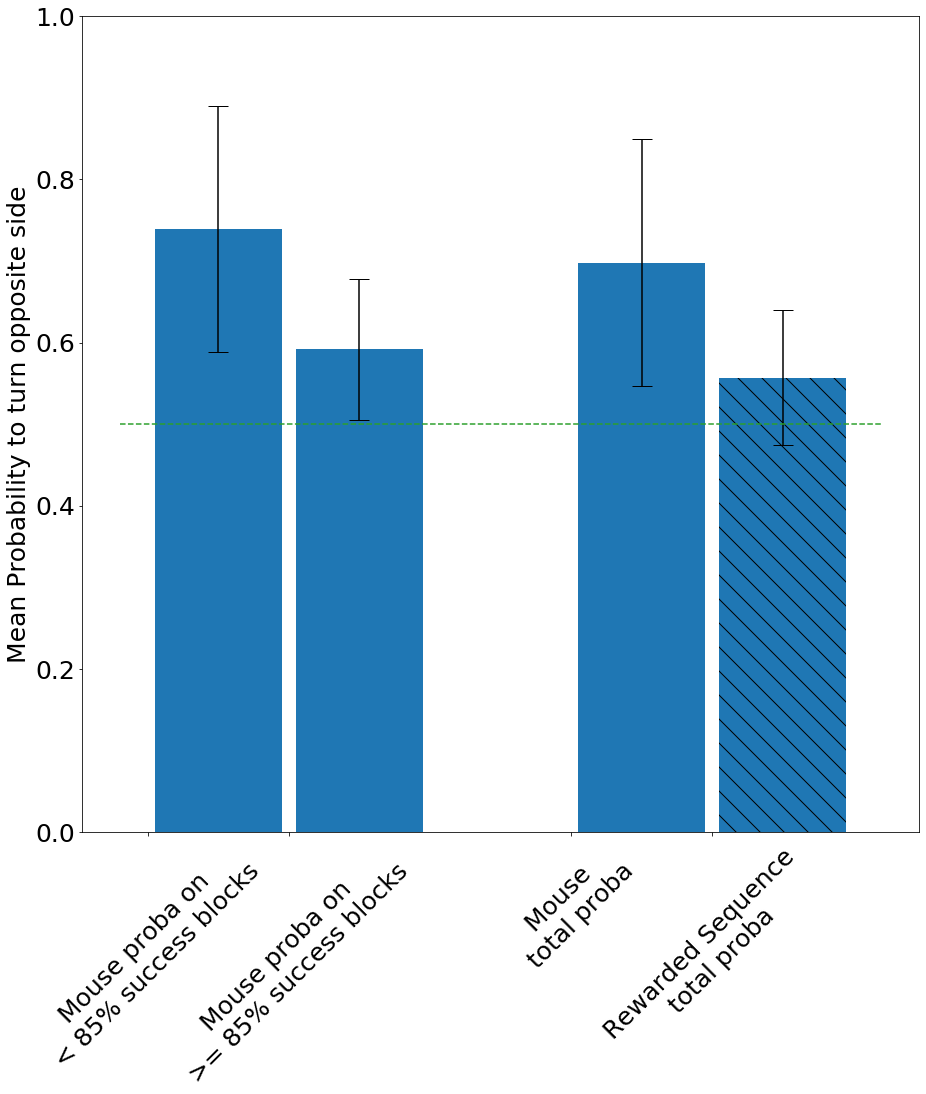

In [7]:
Binsize = -1
ExclusionSize = 15

SucessThreshold = 0.80

SizeReduction = 3

TrainingSets = [26,27,28,30,32]

SUMofmeans_LOPERF = []
SUMofmeans_HIPERF = []
    
SUMofmeans_MOUSE = []
SUMofmeans_SEQ = []


for I in TrainingSets:
    MS=MazeData(I)
    MS.ExtractSequences([3,4,-3,-4])
    MS.CalulateProbas(MS.SessSeqMouse_storage,Binsize,ExclusionSize)
    MS.CalulateSuccessrates(MS.SessSeq_storage,Binsize,ExclusionSize)
    TS=MazeData(I)
    TS.ExtractSequences([3,4,-3,-4])
    TS.CalulateProbas(MS.SessSeqRewd_storage,Binsize,ExclusionSize)
    
    GraphSize = 0
    for U in MS.MouseList:        
        PlotList,NanList=MS.MakePlotlist(MS.Probas_storage,U)
        if np.size(PlotList) > GraphSize :
            GraphSize = np.size(PlotList)
    GraphSize = (GraphSize/SizeReduction) +5
    
    
    fig=plt.figure(figsize=(GraphSize, 20))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    

    
    
    for U in MS.MouseList:
        
        PlotList,NanList=MS.MakePlotlist(MS.Probas_storage,U)
        
        PlotList2,NanList2=TS.MakePlotlist(TS.Probas_storage,U)
        
        PlotList3,NanList3=MS.MakePlotlist(MS.SuccesRate_storage,U)
        
        PlotList4 = np.copy(PlotList)
        
        PlotList5 = np.subtract(PlotList,PlotList2)
        
        MS.Calulate_seqLENGTH(MS.Probas_storage)
        TS.Calulate_seqLENGTH(MS.SuccesRate_storage)
        
        PlotList4[PlotList3 < SucessThreshold] = np.nan
        
        PlotList5[PlotList3 < SucessThreshold] = np.nan
        
        PlotList6 = np.copy(PlotList)
        
        PlotList6[~np.isnan(PlotList4)] = np.nan
        

        SUMofmeans_MOUSE = SUMofmeans_MOUSE + PlotList.tolist()

        SUMofmeans_SEQ = SUMofmeans_SEQ + PlotList2.tolist()
        
        
        if np.size(PlotList6[~np.isnan(PlotList6)])!=0 :
            SUMofmeans_LOPERF = SUMofmeans_LOPERF + PlotList6.tolist()
      
            
        if np.size(PlotList4[~np.isnan(PlotList4)])!=0 :
            SUMofmeans_HIPERF = SUMofmeans_HIPERF + PlotList4.tolist()

        if Binsize != -1:
            Y = np.arange(0, len(PlotList4) * Binsize, Binsize)
        else :
            Y = np.arange(0, len(PlotList4) , 1)
            
        ax1.plot(Y,PlotList4, 'o',markersize=18 ,color = 'tab:orange',zorder = 1)
        ax1.plot(Y,PlotList,'-',color = ColourValues[U],label="mouse {}".format(U),zorder = 3)
        ax1.plot(Y,NanList,'>',markersize=12,color = ColourValues[U],zorder = 4)
        ax1.plot(Y,PlotList2,'--',color = ColourValues[U],label="seqRwd {}".format(U),zorder = 2)
        
        
        ax2.plot(PlotList5, 'o',markersize=18 ,color = 'tab:orange', zorder = 1 )
        ax2.plot(np.subtract(PlotList,PlotList2),'-',color = ColourValues[U],label="Diff {}".format(U))
        ax2.plot(np.subtract(NanList,NanList2),'>',markersize=12,color = ColourValues[U])
    
    ax1.margins(x=0)
    ax1.set_ylim([0.1,1.05])
    start, end = ax1.get_xlim()
    if Binsize != -1 :
        ax1.plot([start-15,end+15],[0.5,0.5], '--', color = 'tab:green',label="Equal turn proba")
        ax1.xaxis.set_ticks(np.arange(0, end, 100))
        ax1.set_xlabel("Number of trials",fontsize=25)
        BinsizeName = str(Binsize)
    else :
        ax1.plot([start-0.5,end+0.5],[0.5,0.5], '--', color = 'tab:green',label="Equal turn proba")
        ax1.set_xlabel("Number of sessions",fontsize=25)
        BinsizeName = "wholesession"
    ax1.legend(bbox_to_anchor=(1.01, 0.5), loc=0, borderaxespad=0)
    
    ax2.set_ylim([-1.1,1.1])
    ax1.set_ylabel("Probability to turn opposite side",fontsize=25)
    
    ax1.tick_params(axis='x', labelsize=25)
    ax1.tick_params(axis='y', labelsize=25)
    
    ax1.text(0, 0, 'SessionMinsize = {}  ;  Blocksize = {}'.format(ExclusionSize,BinsizeName))
    
    ax1.set_title(MS.TrSetName, fontsize=14, fontweight='bold')
    plt.savefig(r'C:\Users\Timothe\NasgoyaveOC\Professionnel\ThèseUNIC\Resultats\Comportement\Plots\GrpAvrilMai19\ProbasTurns\CourbesProbasTurns_binsize{}_mouse{}.png'.format(BinsizeName,MS.TrSetName), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='png',
        transparent=True)
    plt.savefig(r'C:\Users\Timothe\NasgoyaveOC\Professionnel\ThèseUNIC\Resultats\Comportement\Plots\GrpAvrilMai19\ProbasTurns\CourbesProbasTurns_binsize{}_mouse{}.svg'.format(BinsizeName,MS.TrSetName), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='svg',
        transparent=True)
    plt.show()
    

Means=[ np.nanmean(np.asarray(SUMofmeans_LOPERF)), np.nanmean(np.asarray(SUMofmeans_HIPERF)), np.mean(np.asarray(SUMofmeans_MOUSE)), np.mean(np.asarray(SUMofmeans_SEQ))]
STDs =[ np.nanstd(np.asarray(SUMofmeans_LOPERF)), np.nanstd(np.asarray(SUMofmeans_HIPERF)), np.std(np.asarray(SUMofmeans_MOUSE)), np.std(np.asarray(SUMofmeans_SEQ)) ]
    
if len(SUMofmeans_LOPERF) > 0:
    print("Mean of Mouse proba on < 90% success trials",sum(SUMofmeans_LOPERF)/len(SUMofmeans_LOPERF))
if len(SUMofmeans_HIPERF) > 0:
    print("Mean of Mouse proba on >= 90% success trials",sum(SUMofmeans_HIPERF)/len(SUMofmeans_HIPERF))

    
print("Mean mouse -90% correct",np.mean(np.asarray(SUMofmeans_LOPERF)))

print("SD mouse -90% correct",np.std(np.asarray(SUMofmeans_LOPERF)))
print("Var mouse -90% correct",np.var(np.asarray(SUMofmeans_LOPERF)))


print("Mean mouse +90% correct",np.mean(np.asarray(SUMofmeans_HIPERF)))

print("SD mouse +90% correct",np.std(np.asarray(SUMofmeans_HIPERF)))
print("Var mouse +90% correct",np.var(np.asarray(SUMofmeans_HIPERF)))


print("Mean of seq proba to alternate",np.mean(np.asarray(SUMofmeans_MOUSE)))

print("SD mouse total",np.std(np.asarray(SUMofmeans_MOUSE)))
print("Var mouse total",np.var(np.asarray(SUMofmeans_MOUSE)))


print("Mean rew seq total",np.mean(np.asarray(SUMofmeans_SEQ)))

print("SD rew seq total",np.std(np.asarray(SUMofmeans_SEQ)))
print("Var rew seq total",np.var(np.asarray(SUMofmeans_SEQ)))


fig2=plt.figure(figsize=(15, 15))
ax3 = fig2.add_subplot(1, 1, 1)
        
bar=ax3.bar([0, 1, 3, 4],Means, 0.9, yerr=STDs, capsize=10)
start, end = ax3.get_xlim()
ax3.set_ylim([0,1])
ax3.plot([start,end],[0.5,0.5], '--', color = 'tab:green',label="Equal turn proba")
ax3.set_xticks([-0.5, 0.5, 2.5, 3.5])
ax3.set_xticklabels(('Mouse proba on \n< 85% success blocks', 'Mouse proba on \n>= 85% success blocks', 'Mouse \ntotal proba', 'Rewarded Sequence \ntotal proba'), rotation=45, fontsize=25)
ax3.set_ylabel("Mean Probability to turn opposite side",fontsize=25)
ax3.tick_params(axis='y', labelsize=25)

patterns = ('-', '+', 'x', '\\', '*', 'o', 'O', '.')
i=0
for item in bar :
    if i == 3:
        item.set_hatch('\\')
    i=i+1

plt.savefig(r'C:\Users\Timothe\NasgoyaveOC\Professionnel\ThèseUNIC\Resultats\Comportement\Plots\GrpAvrilMai19\ProbasTurns\BarplotsProbasTurns_binsize{}.png'.format(BinsizeName), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='png',
        transparent=True)
plt.savefig(r'C:\Users\Timothe\NasgoyaveOC\Professionnel\ThèseUNIC\Resultats\Comportement\Plots\GrpAvrilMai19\ProbasTurns\BarplotsProbasTurns_binsize{}.svg'.format(BinsizeName), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='svg',
        transparent=True)
plt.show(fig2)

Select: 26 : Phase3_unimodal_b3 : Phase 3 unimodal : choix droite ou gauche selon le stimulus présenté. Les stimulus sont uniquement tactiles


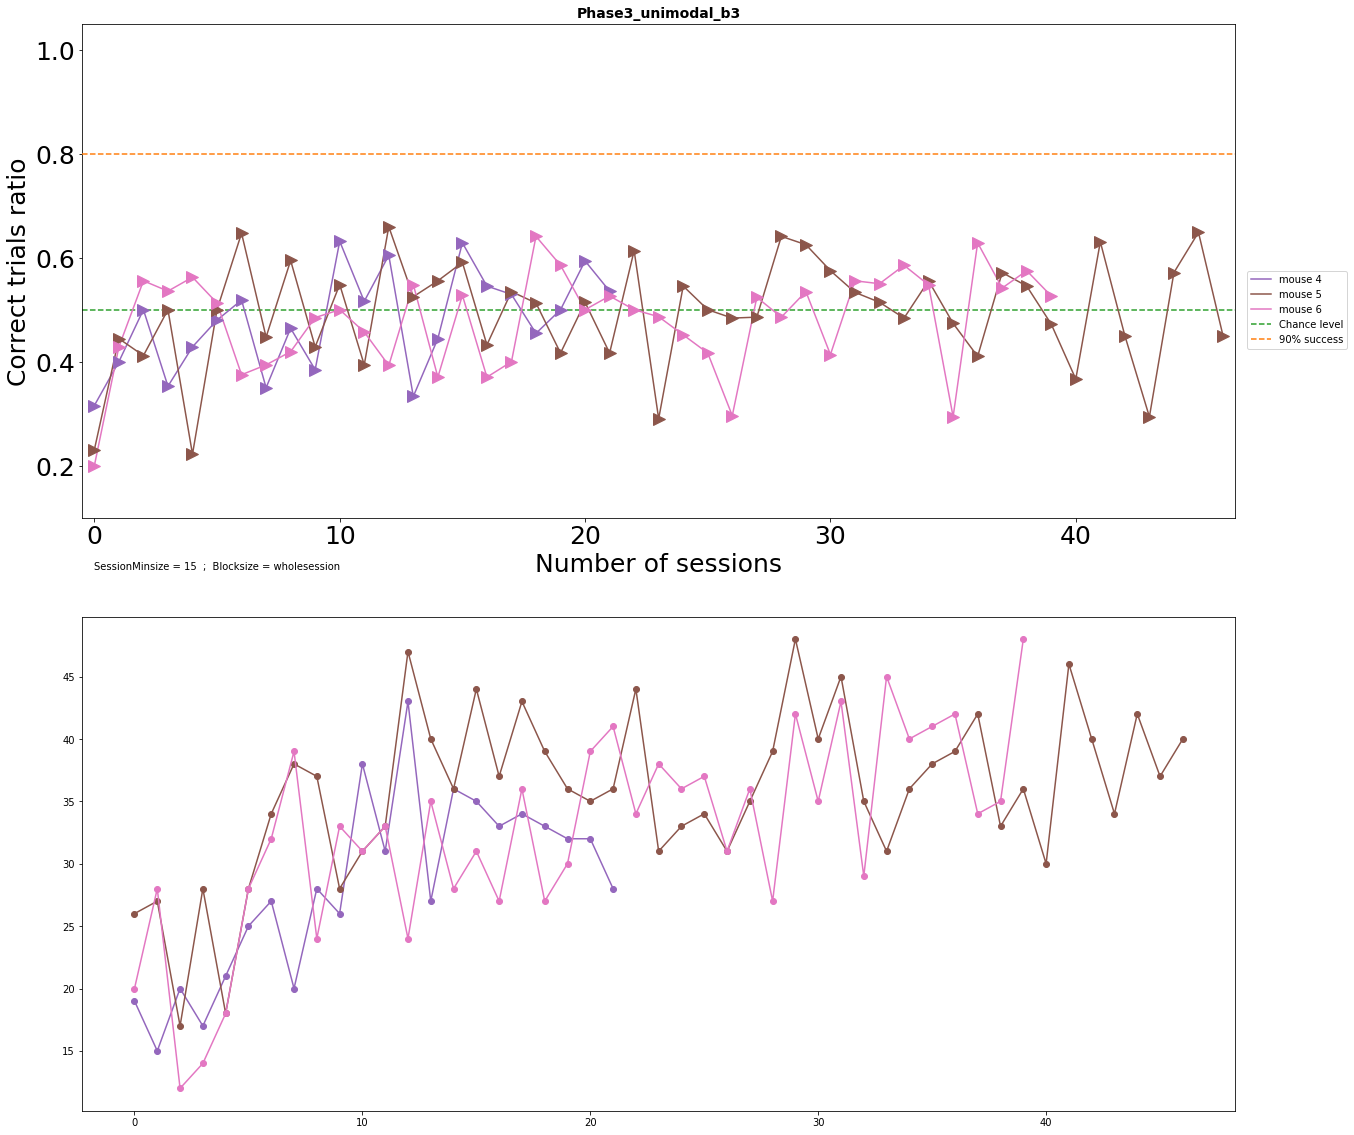

Select: 27 : Phase3_bimodal_a_b3 : Phase 3 bimodal A : choix droite ou gauche selon le stimulus présenté. Les stimulus sont éclairés


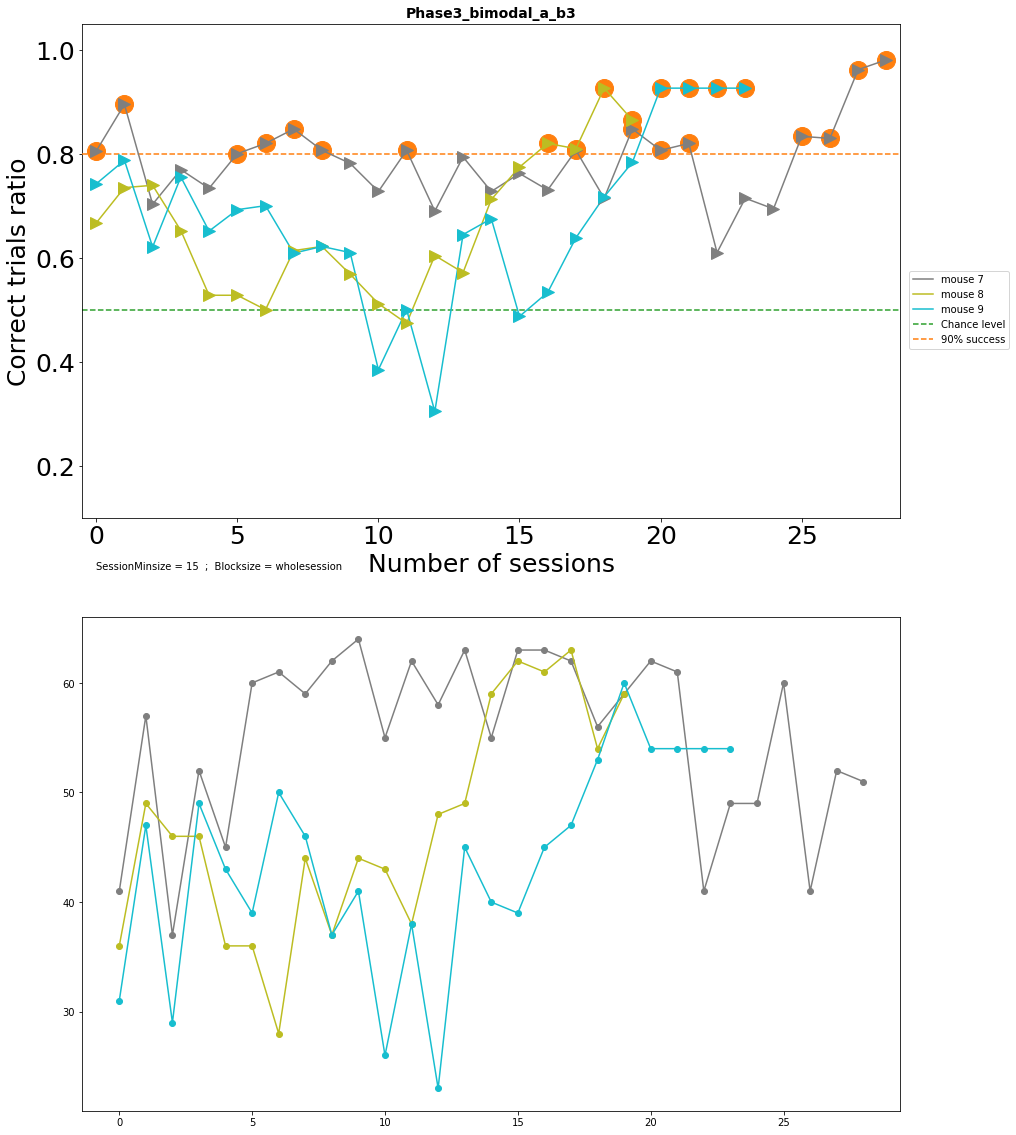

Select: 28 : Phase3_bimodal_b_b3 : Phase 3 bimodal B: choix droite ou gauche selon le stimulus présenté. Les stimulus sont très peu éclairés


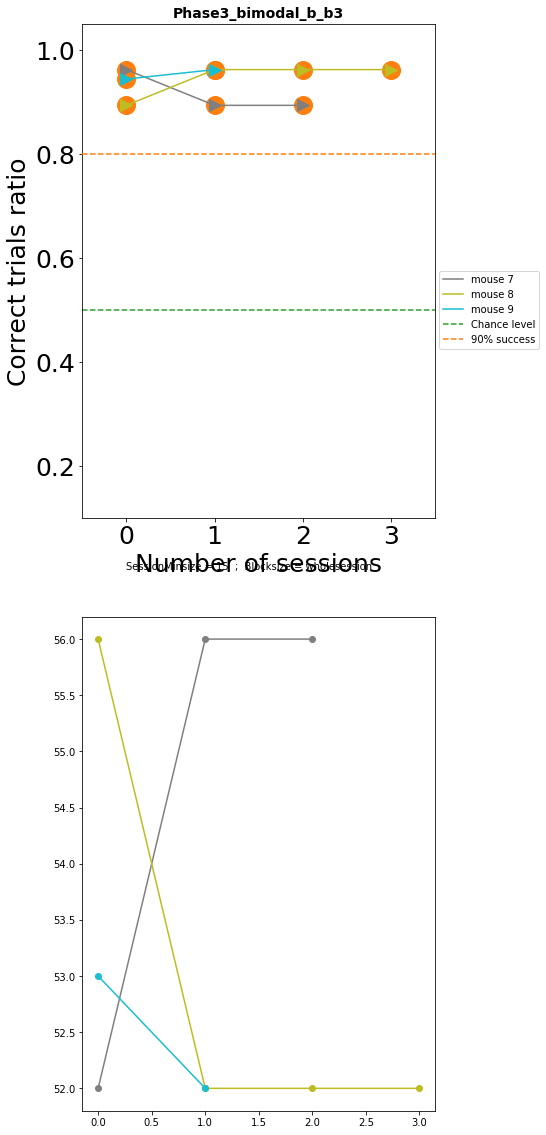

Select: 30 : Phase3_unimodal2_b3 : Phase 3 unimodal : choix droite ou gauche selon le stimulus présenté. Les stimulus sont uniquement tactiles


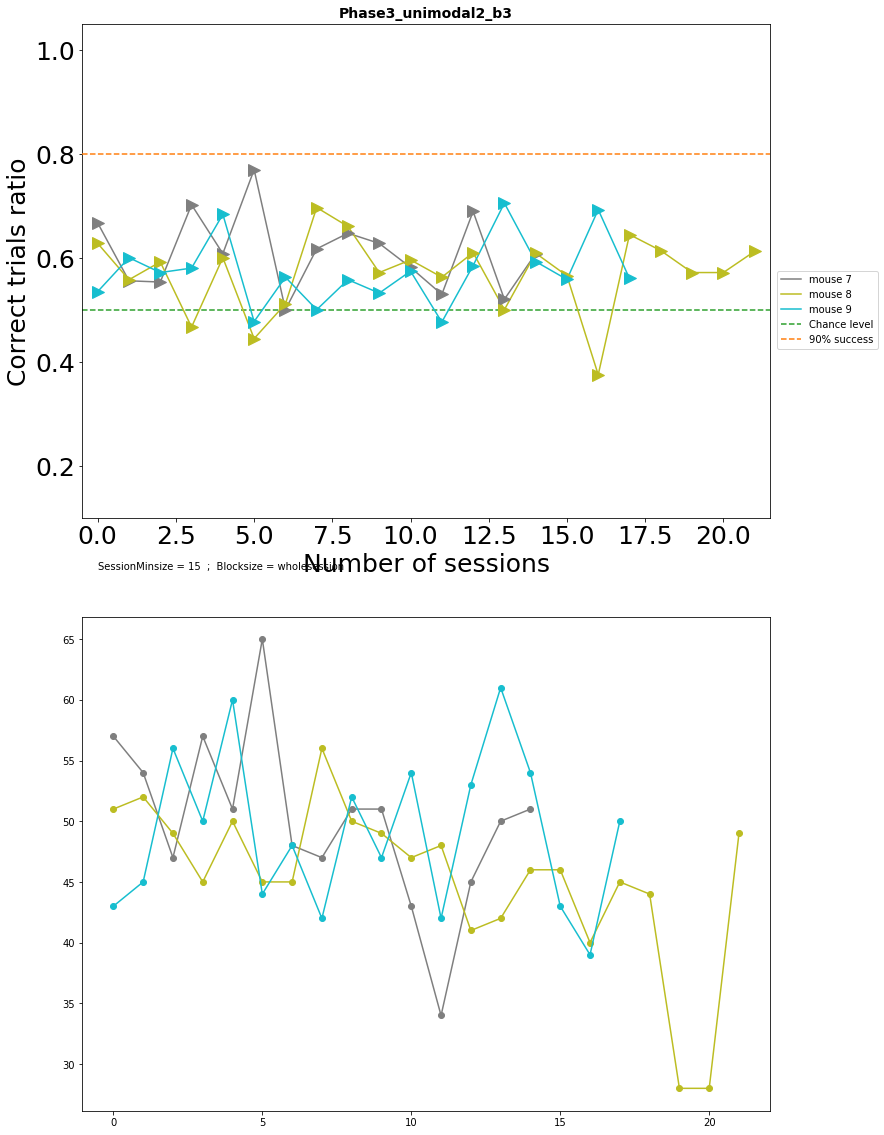

Select: 32 : PhaseX_LedSide_b2 : Phase annexe : souris n'utilisant pas les timuli tactile mais plutôt la position indiquée par les leds proches des lickports pour tourner


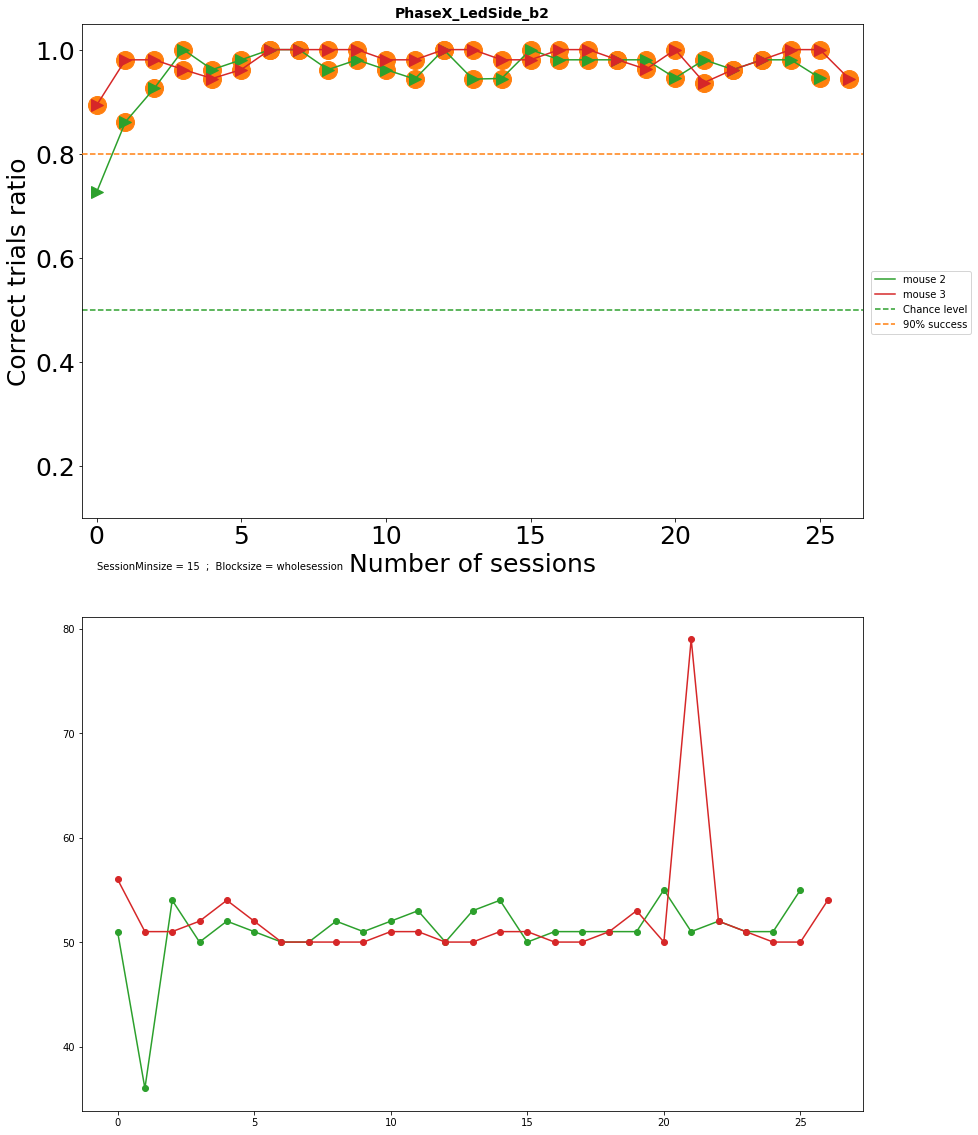

In [8]:
valeur_olds = 20

for I in 26,27,28,30,32:
    MS=MazeData(I)
    if I < valeur_olds :
        seq_values = [1,2,-1,-2]
    else : 
        seq_values = [3,4,-3,-4]
    MS.ExtractSequences(seq_values)
    MS.CalulateSuccessrates(MS.SessSeq_storage,Binsize,ExclusionSize)
    MS.Calulate_seqLENGTH(MS.SessSeq_storage)
    
    GraphSize = 0
    for U in MS.MouseList :        
        PlotList,NanList=MS.MakePlotlist(MS.SuccesRate_storage,U)
        if np.size(PlotList) > GraphSize :
            GraphSize = np.size(PlotList)
            
    GraphSize = (GraphSize/SizeReduction) +5
    
    
    fig=plt.figure(figsize=(GraphSize, 20))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    
    for U in MS.MouseList :
        
        PlotList,NanList=MS.MakePlotlist(MS.SuccesRate_storage,U)
        PlotList2,NanList2=MS.MakePlotlist(MS.Len_storage,U)
        
        PlotList3 = np.copy(PlotList)
        
        PlotList3[PlotList3 < SucessThreshold] = np.nan
        
        if Binsize != -1:
            Y = np.arange(0, len(PlotList) * Binsize, Binsize)
        else :
            Y = np.arange(0, len(PlotList) , 1)
                        
        ax1.plot(Y,PlotList , '-' , color = ColourValues[U] , label="mouse {}".format(U),zorder = 4)
        ax1.plot(Y,NanList , '>' , markersize=12 , color = ColourValues[U],zorder = 5)
        ax1.plot(Y,PlotList3, 'o',markersize=18 ,color = 'tab:orange',zorder = 1)
        
        index = 0
        for I in range(len(NanList)):
            if ~np.isnan(NanList[I]):
                NanList[I] = PlotList2[index]
                index = index + 1
        ax2.plot(NanList,'-o',color = ColourValues[U],label="mouse {}".format(U))
    
    
    ax1.margins(x=0)
    
    start, end = ax1.get_xlim()
    if Binsize != -1 :
        ax1.plot([start-15,end+15],[0.5,0.5], '--', color = 'tab:green',label="Chance level",zorder = 2)
        ax1.plot([start-15,end+15],[SucessThreshold,SucessThreshold], '--', color = 'tab:orange',label="90% success",zorder = 3)
        ax1.xaxis.set_ticks(np.arange(0, end, 100))
        ax1.set_xlabel("Number of trials",fontsize=25)
        BinsizeName = str(Binsize)
    else :
        ax1.plot([start-0.5,end+0.5],[0.5,0.5], '--', color = 'tab:green',label="Chance level",zorder = 2)
        ax1.plot([start-0.5,end+0.5],[SucessThreshold,SucessThreshold], '--', color = 'tab:orange',label="90% success",zorder = 3)
        ax1.set_xlabel("Number of sessions",fontsize=25)
        BinsizeName = "wholesession"
    
    ax1.set_title(MS.TrSetName, fontsize=14, fontweight='bold')
    ax1.text(0, 0, 'SessionMinsize = {}  ;  Blocksize = {}'.format(ExclusionSize,BinsizeName))
    ax1.set_ylim([0.1,1.05])
    ax1.margins(y=0)
    ax1.tick_params(axis='x', labelsize=25)
    ax1.tick_params(axis='y', labelsize=25)
    
    ax1.legend(bbox_to_anchor=(1.01, 0.5), loc=0, borderaxespad=0)
    ax1.set_ylabel("Correct trials ratio",fontsize=25)
    
    plt.savefig(r'C:\Users\Timothe\NasgoyaveOC\Professionnel\ThèseUNIC\Resultats\Comportement\Plots\GrpAvrilMai19\Performances\CourbesPerfs_binsize{}_mouse{}.png'.format(BinsizeName,MS.TrSetName), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='png',
        transparent=True)
    plt.savefig(r'C:\Users\Timothe\NasgoyaveOC\Professionnel\ThèseUNIC\Resultats\Comportement\Plots\GrpAvrilMai19\Performances\CourbesPerfs_binsize{}_mouse{}.svg'.format(BinsizeName,MS.TrSetName), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='svg',
        transparent=True)
    plt.show()

In [ ]:
print(T)
print(np.shape(T))
T=np.append(T,np.array([[1]]),axis=0)
T=np.append(T,np.array([[1]]),axis=0)
U=np.array([[1,2],[3,4]])
List = np.array([[1,2],[3,4]])
U[1,1]=List

In [ ]:
#np.zeros([0,1])
Results = np.zeros([1,2])
print(np.shape(np.array([[3]])))
np.concatenate((Results,np.array([[3]])),axis = 1)